<a href="https://colab.research.google.com/github/cruzdany/KERAS-NLP/blob/main/NLP_Assignment05_Maga%C3%B1a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer
import re
from numpy import *  
import matplotlib.pyplot as plt
import numpy as np
import operator
import nltk
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [2]:
df = pd.read_csv('train.csv',encoding='utf-8',error_bad_lines=False, engine="python")

In [3]:
"""import nltk
nltk.download('stopwords')"""

"import nltk\nnltk.download('stopwords')"

Import Pickle

In [4]:
import re
special_chars = r"[^0-9!@#\$%\^\&\*_\-']"
def Cleaning(tweet,special_chars):
    tweet = re.sub("\d+", "", tweet)
    tweet=re.sub("h[\S]+//[\S]+", "", tweet)
    tweet=re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", tweet)
    tweet=tweet.lower()
    for char in special_chars:
        tweet = tweet.replace(char, "")    
    tweet=tweet.split(" ")
    return ' '.join(tweet)
Cleaned=[]
for t in df["comment_text"]:
    Cleaned.append(Cleaning(t,special_chars))
df['text_generation'] = Cleaned
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,text_generation
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explanationwhy the edits made under my usernam...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,daww he matches this background colour im seem...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,hey man im really not trying to edit war its j...
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,morei cant make any real suggestions on improv...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,you sir are my hero any chance you remember wh...


In [5]:
df.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate', 'text_generation'],
      dtype='object')

In [6]:
y = df[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.text_generation, y, test_size=0.2,
                                                    random_state=np.random)
print(X_train.shape, X_test.shape, len(y_train), len(y_test))

(127656,) (31915,) 127656 31915


In [8]:
from keras.preprocessing.text import Tokenizer
from keras import initializers, regularizers, constraints, optimizers, layers

max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
list_tokenized_train = tokenizer.texts_to_sequences(X_train)
list_tokenized_test = tokenizer.texts_to_sequences(X_test)
maxlen=400
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
list_tokenized_train = tokenizer.texts_to_sequences(X_train)
list_tokenized_test = tokenizer.texts_to_sequences(X_test)
V_train = pad_sequences(list_tokenized_train, maxlen=maxlen)
V_test = pad_sequences(list_tokenized_test, maxlen=maxlen)
print(V_train.shape,V_test.shape)

(127656, 400) (31915, 400)


In [9]:
def getModel():
    inp = Input(shape=(maxlen, ))
    embed_size = 128
    x = Embedding(max_features, embed_size)(inp)
    x = LSTM(30, return_sequences=True,name='lstm_layer')(x)
    x = GlobalMaxPool1D()(x)
    x = Dropout(0.2)(x)
    x = Dense(20, activation="relu")(x)
    x = Dropout(0.2)(x)
    x = Dense(6, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
    return model

In [10]:
model = getModel()
batch_size = 32
epochs = 3
file_path="../weights_base.best.hdf5"
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

early = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=2)


callbacks_list = [checkpoint, early] #early
history = model.fit(V_train,y_train,  batch_size=batch_size, epochs=epochs, 
                    validation_split=0.1, callbacks=callbacks_list)

Epoch 1/3
3591/3591 [==============================] - ETA: 0s - loss: 0.0844 - accuracy: 0.8629
Epoch 00001: val_loss improved from inf to 0.05314, saving model to ../weights_base.best.hdf5
3591/3591 [==============================] - 743s 207ms/step - loss: 0.0844 - accuracy: 0.8629 - val_loss: 0.0531 - val_accuracy: 0.9951
Epoch 2/3
3591/3591 [==============================] - ETA: 0s - loss: 0.0507 - accuracy: 0.9875
Epoch 00002: val_loss improved from 0.05314 to 0.05185, saving model to ../weights_base.best.hdf5
3591/3591 [==============================] - 748s 208ms/step - loss: 0.0507 - accuracy: 0.9875 - val_loss: 0.0519 - val_accuracy: 0.9951
Epoch 3/3
3591/3591 [==============================] - ETA: 0s - loss: 0.0449 - accuracy: 0.9694
Epoch 00003: val_loss did not improve from 0.05185
3591/3591 [==============================] - 748s 208ms/step - loss: 0.0449 - accuracy: 0.9694 - val_loss: 0.0519 - val_accuracy: 0.9948


In [12]:
y_pred = model.predict(V_test)
print(classification_report(y_test,y_pred.round(),digits=2))

              precision    recall  f1-score   support

           0       0.84      0.72      0.77      2972
           1       0.54      0.10      0.17       293
           2       0.83      0.77      0.80      1607
           3       0.00      0.00      0.00        90
           4       0.73      0.69      0.71      1501
           5       0.00      0.00      0.00       271

   micro avg       0.81      0.66      0.73      6734
   macro avg       0.49      0.38      0.41      6734
weighted avg       0.75      0.66      0.70      6734
 samples avg       0.06      0.06      0.06      6734



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
y_pred

array([[1.6146448e-01, 1.5658140e-04, 1.4845520e-02, 1.3121068e-03,
        3.3656865e-02, 4.4333339e-03],
       [2.9761195e-03, 2.0800821e-06, 5.4389238e-04, 1.3007881e-05,
        2.0766258e-04, 6.3360327e-05],
       [1.0298491e-03, 4.6301476e-08, 9.6066477e-05, 9.1526192e-07,
        4.3254287e-05, 8.3588066e-06],
       ...,
       [3.6251545e-04, 2.0339192e-08, 5.2464973e-05, 2.6866110e-07,
        1.2360515e-05, 2.3566845e-06],
       [2.7316809e-04, 8.3871967e-09, 2.7107832e-05, 1.7304296e-07,
        8.7984590e-06, 1.8517879e-06],
       [4.6801567e-04, 1.6987387e-08, 5.1637493e-05, 2.9954055e-07,
        1.5355661e-05, 3.1810889e-06]], dtype=float32)

In [14]:
y_test

,toxic,severe_toxic,obscene,threat,insult,identity_hate
26101,0,0,0,0,0,0
55360,0,0,0,0,0,0
65919,0,0,0,0,0,0
19512,0,0,0,0,0,0
24174,0,0,0,0,0,0
...,...,...,...,...,...,...
112049,0,0,0,0,0,0
118445,0,0,0,0,0,0
148382,0,0,0,0,0,0
156165,0,0,0,0,0,0


In [15]:
df.shape

(159571, 9)

In [16]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [22]:
import matplotlib.pyplot as plt
import math 

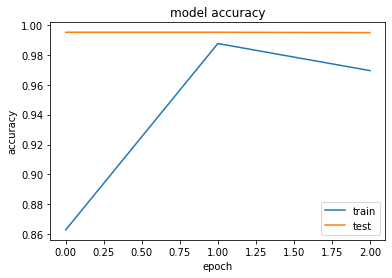

In [29]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

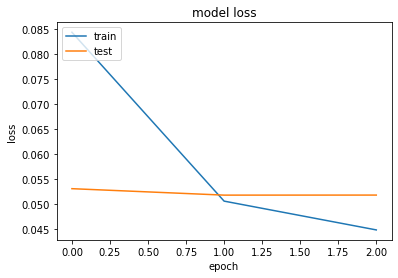

In [28]:
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [44]:
from sklearn.metrics import f1_score, make_scorer, confusion_matrix, accuracy_score, precision_score, recall_score, precision_recall_curve

In [45]:
y_val_pred_cat1 = (np.asarray(y_pred)).round()

In [46]:
y_val_pred_cat1

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]], dtype=float32)

In [53]:
f1_score(y_test, y_val_pred_cat1, average='macro')

0.4086123022659552